In [1]:
import findspark
findspark.init()

In [2]:
from pyspark import SparkContext
sc = SparkContext()

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [4]:
#funtion for CSV conversion
def xml2csv(line,tags_list):
    offset=0
    result=""
    for i in tags_list:
        val=""
        patt=i+"="
        ind=line.find(patt,offset)
        if(ind==-1):
            result+=','
            continue
        ind+=(len(i)+2)
        val+='\"'
        while(line[ind]!='\"'):
            val+=line[ind]
            ind+=1
        val+='\"'
        result+=val+','
        offset=ind
    return result[:-1]

In [5]:
fileName = 's3://my4dbucket/math/Posts.xml'

In [6]:
# The raw XML file
raw = (sc.textFile(fileName, 4))

In [7]:
#Removing top 2 lines form XML file,they're just XML root
headers = raw.take(2)
UsersRDD = raw.filter(lambda x: (x != headers[0]) & (x != headers[1]))

In [8]:
#Take a quick look at XML file
UsersRDD.take(3)

['  <row Id="1" PostTypeId="1" AcceptedAnswerId="9" CreationDate="2010-07-20T19:09:27.200" Score="156" ViewCount="8964" Body="&lt;p&gt;Can someone explain to me how there can be different kinds of infinities?&lt;/p&gt;&#xA;&#xA;&lt;p&gt;I was reading &quot;&lt;a href=&quot;http://en.wikipedia.org/wiki/The_Man_Who_Loved_Only_Numbers&quot; rel=&quot;noreferrer&quot;&gt;The man who loved only numbers&lt;/a&gt;&quot; by &lt;a href=&quot;http://en.wikipedia.org/wiki/Paul_Hoffman_(science_writer)&quot; rel=&quot;noreferrer&quot;&gt;Paul Hoffman&lt;/a&gt; and came across the concept of countable and uncountable infinities, but they\'re only words to me.&lt;/p&gt;&#xA;&#xA;&lt;p&gt;Any help would be appreciated.&lt;/p&gt;&#xA;" OwnerUserId="10" LastEditorUserId="32803" LastEditorDisplayName="user126" LastEditDate="2018-03-01T19:53:22.017" LastActivityDate="2020-01-28T03:26:12.530" Title="What Does it Really Mean to Have Different Kinds of Infinities?" Tags="&lt;elementary-set-theory&gt;&lt;int

In [9]:
#FieldNames for Analyze
tags_list=['Id', 'PostTypeId', 'CreationDate', 'Score', 'ViewCount', 'Tags', 'AnswerCount', 'CommentCount']

In [10]:
#Turn RDD to csv format
Users_csvRDD=UsersRDD.map(lambda x:xml2csv(x,tags_list))

In [11]:
#Take a look at the data after conversion
Users_csvRDD.take(3)

['"1","1","2010-07-20T19:09:27.200","156","8964","&lt;elementary-set-theory&gt;&lt;intuition&gt;&lt;infinity&gt;&lt;faq&gt;","9","0"',
 '"3","1","2010-07-20T19:12:14.353","120","71991","&lt;soft-question&gt;&lt;big-list&gt;&lt;online-resources&gt;","21","4"',
 '"4","2","2010-07-20T19:14:10.603","11",,,,"2"']

In [12]:
#Folder path to save processed files
targetFile = './Post_csv'

In [13]:
#Save file
Users_csvRDD.saveAsTextFile(targetFile)

In [14]:
#Read in csv file
post = sc.textFile('./Post_csv').cache()

In [15]:
#Take a look at the data after reading in
post.take(3)

['"1","1","2010-07-20T19:09:27.200","156","8964","&lt;elementary-set-theory&gt;&lt;intuition&gt;&lt;infinity&gt;&lt;faq&gt;","9","0"',
 '"3","1","2010-07-20T19:12:14.353","120","71991","&lt;soft-question&gt;&lt;big-list&gt;&lt;online-resources&gt;","21","4"',
 '"4","2","2010-07-20T19:14:10.603","11",,,,"2"']

In [16]:
import sys
import os,datetime,re

#Turn data into different parts for further use
class math_post():
    def __init__(self, record):
        self.Id = re.split(",(?=(?:[^\"]*\"[^\"]*\")*[^\"]*$)", record)[0]
        self.PostTypeId = re.split(",(?=(?:[^\"]*\"[^\"]*\")*[^\"]*$)", record)[1]
        self.CreationDate = re.split(",(?=(?:[^\"]*\"[^\"]*\")*[^\"]*$)", record)[2]
        self.Score = re.split(",(?=(?:[^\"]*\"[^\"]*\")*[^\"]*$)", record)[3]
        self.ViewCount = re.split(",(?=(?:[^\"]*\"[^\"]*\")*[^\"]*$)" , record)[4]
        self.Tags = re.split(",(?=(?:[^\"]*\"[^\"]*\")*[^\"]*$)" , record)[5]
        self.AnswerCount = re.split(",(?=(?:[^\"]*\"[^\"]*\")*[^\"]*$)" , record)[6]
        self.CommentCount = re.split(",(?=(?:[^\"]*\"[^\"]*\")*[^\"]*$)" , record)[7]

In [17]:
from pyspark.sql import Row
#Turn data into rows
lines = post.map(lambda record: math_post(record)).map(lambda q: Row(Id = q.Id,
                                                                     PostTypeId = q.PostTypeId,
                                                                     CreationDate= q.CreationDate,
                                                                     Score = q.Score,
                                                                     ViewCount = q.ViewCount,
                                                                     Tags = q.Tags,
                                                                     AnswerCount = q.AnswerCount,
                                                                     CommentCount = q.CommentCount
                                                                    ))
lines.take(3)

[Row(AnswerCount='"9"', CommentCount='"0"', CreationDate='"2010-07-20T19:09:27.200"', Id='"1"', PostTypeId='"1"', Score='"156"', Tags='"&lt;elementary-set-theory&gt;&lt;intuition&gt;&lt;infinity&gt;&lt;faq&gt;"', ViewCount='"8964"'),
 Row(AnswerCount='"21"', CommentCount='"4"', CreationDate='"2010-07-20T19:12:14.353"', Id='"3"', PostTypeId='"1"', Score='"120"', Tags='"&lt;soft-question&gt;&lt;big-list&gt;&lt;online-resources&gt;"', ViewCount='"71991"'),
 Row(AnswerCount='', CommentCount='"2"', CreationDate='"2010-07-20T19:14:10.603"', Id='"4"', PostTypeId='"2"', Score='"11"', Tags='', ViewCount='')]

In [18]:
#Create a dataframe and cache it for quick use
temp = spark.createDataFrame(lines).cache()

In [19]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.functions import unix_timestamp, from_unixtime

def stripDQ(string):
    return string.replace('"', "")
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, IntegerType
udf_stripDQ = udf(stripDQ, StringType())

In [20]:
#Get rid of the qoutes
post_df = temp.withColumn("ViewCount", udf_stripDQ(temp["ViewCount"]))
post_df = post_df.withColumn("CreationDate", udf_stripDQ(temp["CreationDate"]))
post_df = post_df.withColumn("Id", udf_stripDQ(temp["Id"]))
post_df = post_df.withColumn("Score", udf_stripDQ(temp["Score"]))
post_df = post_df.withColumn("PostTypeId", udf_stripDQ(temp["PostTypeId"]))
post_df = post_df.withColumn("Tags", udf_stripDQ(temp["Tags"]))
post_df = post_df.withColumn("AnswerCount", udf_stripDQ(temp["AnswerCount"]))
post_df = post_df.withColumn("CommentCount", udf_stripDQ(temp["CommentCount"]))

In [21]:
#Cast data to integer data type
post_df = post_df.withColumn("Score", post_df["Score"].cast(IntegerType()))
post_df = post_df.withColumn("AnswerCount", post_df["AnswerCount"].cast(IntegerType()))
post_df = post_df.withColumn("CommentCount", post_df["CommentCount"].cast(IntegerType()))
post_df = post_df.withColumn("ViewCount", post_df["ViewCount"].cast(IntegerType()))
post_df = post_df.withColumn("PostTypeId", post_df["PostTypeId"].cast(IntegerType()))
post_df = post_df.fillna(0, subset=['AnswerCount', 'ViewCount', 'CommentCount', 'Score'])

In [22]:
#The integer type column with null values are filled with 0
post_df.show(5)

+-----------+------------+--------------------+---+----------+-----+--------------------+---------+
|AnswerCount|CommentCount|        CreationDate| Id|PostTypeId|Score|                Tags|ViewCount|
+-----------+------------+--------------------+---+----------+-----+--------------------+---------+
|          9|           0|2010-07-20T19:09:...|  1|         1|  156|&lt;elementary-se...|     8964|
|         21|           4|2010-07-20T19:12:...|  3|         1|  120|&lt;soft-question...|    71991|
|          0|           2|2010-07-20T19:14:...|  4|         2|   11|                    |        0|
|         14|           7|2010-07-20T19:18:...|  5|         1|   53|&lt;elementary-nu...|    13293|
|          9|           0|2010-07-20T19:20:...|  6|         1|   42|&lt;soft-question...|     5273|
+-----------+------------+--------------------+---+----------+-----+--------------------+---------+
only showing top 5 rows



In [23]:
#Take a quick look at data schema
post_df.printSchema()

root
 |-- AnswerCount: integer (nullable = true)
 |-- CommentCount: integer (nullable = true)
 |-- CreationDate: string (nullable = true)
 |-- Id: string (nullable = true)
 |-- PostTypeId: integer (nullable = true)
 |-- Score: integer (nullable = true)
 |-- Tags: string (nullable = true)
 |-- ViewCount: integer (nullable = true)



In [24]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline
import datetime

from sklearn.metrics import f1_score, recall_score, precision_score
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType, DoubleType, DateType, FloatType

## EDA

In [25]:
#create a new table
post_df.createOrReplaceTempView("post_tbl")

In our data the highest score is 1289 and it's created on 2011-02-09

In [26]:
spark.sql("SELECT Score, CreationDate FROM post_tbl ORDER BY Score DESC").show(1, truncate = False)

+-----+-----------------------+
|Score|CreationDate           |
+-----+-----------------------+
|1289 |2011-02-09T17:05:55.190|
+-----+-----------------------+
only showing top 1 row



The post with most view count scores 33, and it's created on 2014-03-01

In [27]:
spark.sql("SELECT Score, ViewCount, CreationDate FROM post_tbl ORDER BY ViewCount DESC").show(1, truncate = False)

+-----+---------+-----------------------+
|Score|ViewCount|CreationDate           |
+-----+---------+-----------------------+
|33   |705193   |2014-03-01T23:24:35.993|
+-----+---------+-----------------------+
only showing top 1 row



The post with highest score is type 2, answer.

In [28]:
spark.sql("SELECT Score, PostTypeId FROM post_tbl ORDER BY Score DESC").show(1, truncate = False)

+-----+----------+
|Score|PostTypeId|
+-----+----------+
|1289 |2         |
+-----+----------+
only showing top 1 row



The post with most comment count scores 3, and it's created on 2019-03-04

In [29]:
spark.sql("SELECT Score, CommentCount, CreationDate FROM post_tbl ORDER BY CommentCount DESC").show(1, truncate = False)

+-----+------------+-----------------------+
|Score|CommentCount|CreationDate           |
+-----+------------+-----------------------+
|3    |111         |2019-03-04T15:40:11.613|
+-----+------------+-----------------------+
only showing top 1 row



The post with most answer count scores 665, and it's created on 2013-03-07

In [30]:
spark.sql("SELECT Score, AnswerCount, CreationDate FROM post_tbl ORDER BY AnswerCount DESC").show(1, truncate = False)

+-----+-----------+-----------------------+
|Score|AnswerCount|CreationDate           |
+-----+-----------+-----------------------+
|665  |164        |2013-03-07T06:50:31.370|
+-----+-----------+-----------------------+
only showing top 1 row



### To have a more straightforward understanding, we take 1% of the data for plotting

In [31]:
# Sample 1% data for data exploration
post_sampled_df = post_df.sample(False,0.01,1)
post_sampled_pd = post_sampled_df.toPandas()

/home/hadoop/miniconda/lib/python3.7/site-packages/pyarrow/util.py:39: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead
  warnings.warn(msg, FutureWarning)


The score distribution in general:

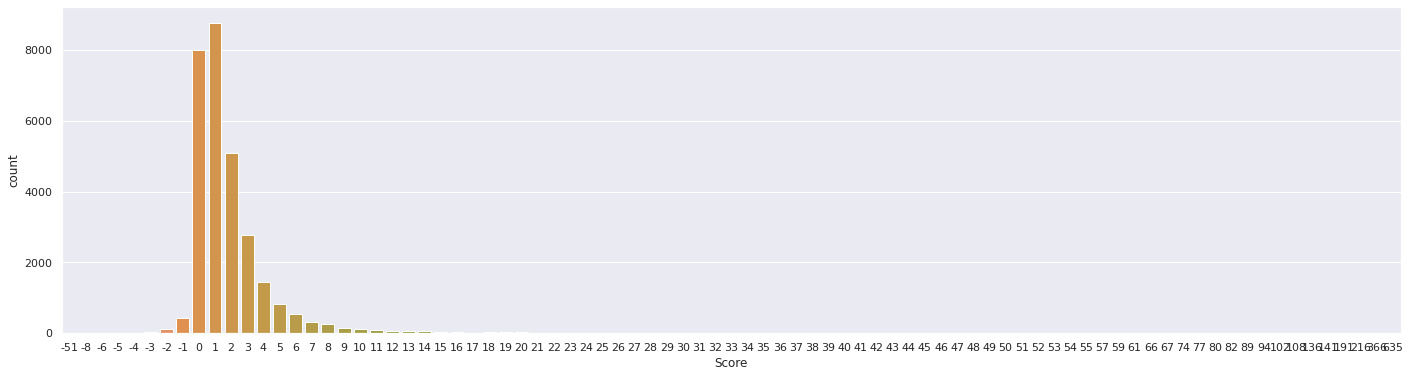

In [32]:
plt.figure(figsize=(24, 6))
ax = sns.countplot(x="Score", data=post_sampled_pd)

#### Post Type

In [33]:
# The major post type in the data and related mean score
groupby_post_type_pd = pd.DataFrame({'Percentage': post_sampled_pd.groupby('PostTypeId').size() / len(post_sampled_pd), 
                                     'Mean_Score': post_sampled_pd.groupby(('PostTypeId'))['Score'].mean()})
groupby_post_type_pd

,Percentage,Mean_Score
PostTypeId,,
1,0.420894,1.925352
2,0.577753,2.201428
4,0.000643,0.000000
5,0.000643,0.000000
6,0.000068,-25.500000


As we can tell from the table, the score is related to post type and the major post type is 1(question) and 2(answer). There're more answers in this forum and the average score tends to be higher as well. 

#### View Count

Text(0, 0.5, 'Score')

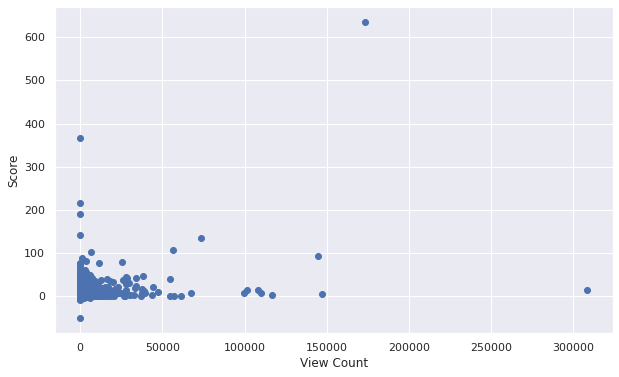

In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(post_sampled_pd['ViewCount'], post_sampled_pd['Score'])
plt.xlabel('View Count')
plt.ylabel('Score')

In [35]:
groupby_viewcount_pd = pd.DataFrame({'Mean_Score': post_sampled_pd.groupby(['ViewCount'])['Score'].mean()}).reset_index()
groupby_viewcount_pd.sort_values('Mean_Score', ascending=False)

,ViewCount,Mean_Score
1933,172997,635.0
1925,73465,136.0
1921,56648,108.0
1740,6523,102.0
1931,144773,94.0
...,...,...
1131,1402,-2.0
1541,3075,-2.0
1512,2856,-2.0
1720,5811,-3.0


Most of the post doesn't have high view times or score, and the data are focusing in the bottom left. We group by the data and find the posts with highest mean score are single point.

#### Comment Count

Text(0, 0.5, 'Score')

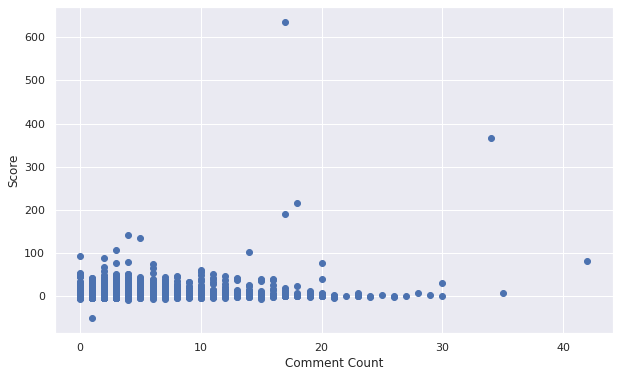

In [36]:
plt.figure(figsize=(10, 6))
plt.scatter(post_sampled_pd['CommentCount'], post_sampled_pd['Score'])
plt.xlabel('Comment Count')
plt.ylabel('Score')

#### Answer Count

Text(0, 0.5, 'Score')

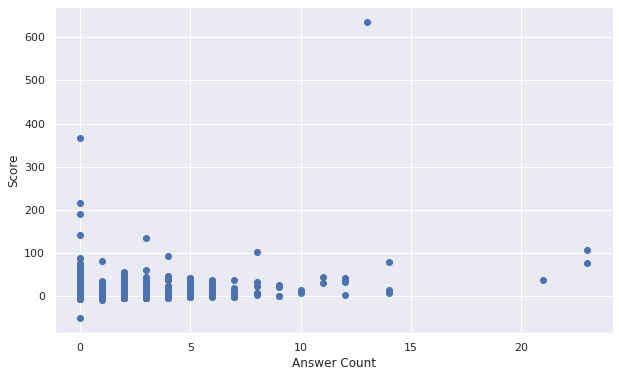

In [37]:
plt.figure(figsize=(10, 6))
plt.scatter(post_sampled_pd['AnswerCount'], post_sampled_pd['Score'])
plt.xlabel('Answer Count')
plt.ylabel('Score')

## Feature Engineering

* As we can tell from the plot, the score value is too scattered, so we manually set a threashold for classifaction.
* The post score is related to the people votes, so the time when the post is created is related to the number of users who can see this post and how easy the question could be. So the post score is related to time in our assumption. As we can tell, the Creation Year and Month are integer

In [38]:
post_df = post_df.withColumn("CreationDate_date", to_date(col("CreationDate")))
post_df = post_df.withColumn('CreationYear',year(post_df.CreationDate_date))
post_df = post_df.withColumn('CreationMonth',month(post_df.CreationDate_date))

In [39]:
post_df = post_df.withColumn('label',
                             F.when((F.col("Score") >= 5), 1).otherwise(0))
post_df.show()

+-----------+------------+--------------------+---+----------+-----+--------------------+---------+-----------------+------------+-------------+-----+
|AnswerCount|CommentCount|        CreationDate| Id|PostTypeId|Score|                Tags|ViewCount|CreationDate_date|CreationYear|CreationMonth|label|
+-----------+------------+--------------------+---+----------+-----+--------------------+---------+-----------------+------------+-------------+-----+
|          9|           0|2010-07-20T19:09:...|  1|         1|  156|&lt;elementary-se...|     8964|       2010-07-20|        2010|            7|    1|
|         21|           4|2010-07-20T19:12:...|  3|         1|  120|&lt;soft-question...|    71991|       2010-07-20|        2010|            7|    1|
|          0|           2|2010-07-20T19:14:...|  4|         2|   11|                    |        0|       2010-07-20|        2010|            7|    1|
|         14|           7|2010-07-20T19:18:...|  5|         1|   53|&lt;elementary-nu...|    1

In [40]:
post_df.printSchema()

root
 |-- AnswerCount: integer (nullable = true)
 |-- CommentCount: integer (nullable = true)
 |-- CreationDate: string (nullable = true)
 |-- Id: string (nullable = true)
 |-- PostTypeId: integer (nullable = true)
 |-- Score: integer (nullable = true)
 |-- Tags: string (nullable = true)
 |-- ViewCount: integer (nullable = true)
 |-- CreationDate_date: date (nullable = true)
 |-- CreationYear: integer (nullable = true)
 |-- CreationMonth: integer (nullable = true)
 |-- label: integer (nullable = false)



## Building Model

In [41]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model

Build a assembler containing all the features we have

In [42]:
# Let us import the vector assembler
from pyspark.ml.feature import VectorAssembler
numericCols = ["AnswerCount",
               "CommentCount",
               "ViewCount",
               "CreationYear",
               "CreationMonth",
               "PostTypeId"]

assembler = VectorAssembler(inputCols=numericCols, outputCol="features",handleInvalid="skip")

Create a new dataframe containing features we create and predicted values

In [43]:
#use the transform method to transform our dataset
# cols = post_df.columns
post_df = assembler.transform(post_df)
selectedCols = ["features", "label"] 
df = post_df.select(selectedCols)

Split the data into train and test dataset

In [44]:
train, test = df.randomSplit([0.7, 0.3], seed = 985)

In [45]:
train.show(5, truncate = False)

+----------------------------+-----+
|features                    |label|
+----------------------------+-----+
|[0.0,0.0,0.0,2010.0,7.0,2.0]|0    |
|[0.0,0.0,0.0,2010.0,7.0,2.0]|0    |
|[0.0,0.0,0.0,2010.0,7.0,2.0]|0    |
|[0.0,0.0,0.0,2010.0,7.0,2.0]|0    |
|[0.0,0.0,0.0,2010.0,7.0,2.0]|0    |
+----------------------------+-----+
only showing top 5 rows



### Logistic Regression

Model fitting

In [46]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

Plot the ROC curve and calculate the area under the ROC curve for training set

/home/hadoop/miniconda/lib/python3.7/site-packages/pyarrow/util.py:39: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead
  warnings.warn(msg, FutureWarning)


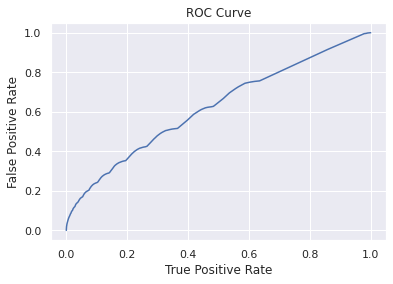

Training set areaUnderROC: 0.6213395905828555


In [48]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

Transform dataframe into prediction

In [49]:
predictions = lrModel.transform(test)
predictions.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[0.0,0.0,0.0,2010...|    0|[2.21678342846609...|[0.90174657651085...|       0.0|
|[0.0,0.0,0.0,2010...|    0|[2.21678342846609...|[0.90174657651085...|       0.0|
|[0.0,0.0,0.0,2010...|    0|[2.21678342846609...|[0.90174657651085...|       0.0|
|[0.0,0.0,0.0,2010...|    0|[2.21678342846609...|[0.90174657651085...|       0.0|
|[0.0,0.0,0.0,2010...|    0|[2.21678342846609...|[0.90174657651085...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



Calculate the test area under the ROC curve

In [50]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.6216519027837475


### Random Forest Classifier

Model fitting

In [51]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.show(10)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[0.0,0.0,0.0,2010...|    0|[17.1301538731863...|[0.85650769365931...|       0.0|
|[0.0,0.0,0.0,2010...|    0|[17.1301538731863...|[0.85650769365931...|       0.0|
|[0.0,0.0,0.0,2010...|    0|[17.1301538731863...|[0.85650769365931...|       0.0|
|[0.0,0.0,0.0,2010...|    0|[17.1301538731863...|[0.85650769365931...|       0.0|
|[0.0,0.0,0.0,2010...|    0|[17.1301538731863...|[0.85650769365931...|       0.0|
|[0.0,0.0,0.0,2010...|    0|[17.1301538731863...|[0.85650769365931...|       0.0|
|[0.0,0.0,0.0,2010...|    0|[17.1301538731863...|[0.85650769365931...|       0.0|
|[0.0,0.0,0.0,2010...|    0|[17.1301538731863...|[0.85650769365931...|       0.0|
|[0.0,0.0,0.0,2010...|    0|[17.1301538731863...|[0.85650769365931...|       0.0|
|[0.0,0.0,0.0,20

Calculate the test area under the ROC curve

In [52]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7083866369392214


### Gradient Boosting

Model fitting

In [53]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.show(10)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[0.0,0.0,0.0,2010...|    0|[0.19228872580735...|[0.59497665248261...|       0.0|
|[0.0,0.0,0.0,2010...|    0|[0.19228872580735...|[0.59497665248261...|       0.0|
|[0.0,0.0,0.0,2010...|    0|[0.19228872580735...|[0.59497665248261...|       0.0|
|[0.0,0.0,0.0,2010...|    0|[0.19228872580735...|[0.59497665248261...|       0.0|
|[0.0,0.0,0.0,2010...|    0|[0.19228872580735...|[0.59497665248261...|       0.0|
|[0.0,0.0,0.0,2010...|    0|[0.19228872580735...|[0.59497665248261...|       0.0|
|[0.0,0.0,0.0,2010...|    0|[0.19228872580735...|[0.59497665248261...|       0.0|
|[0.0,0.0,0.0,2010...|    0|[0.19228872580735...|[0.59497665248261...|       0.0|
|[0.0,0.0,0.0,2010...|    0|[0.19228872580735...|[0.59497665248261...|       0.0|
|[0.0,0.0,0.0,20

Calculate the test area under the ROC curve

In [54]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7692929497129346


Feature importance score in the form of a sparse vector

In [65]:
gbtModel.featureImportances

SparseVector(6, {0: 0.0509, 1: 0.1492, 2: 0.2929, 3: 0.3615, 4: 0.0323, 5: 0.1131})

Map this sparse vector to the actual feature names

In [66]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

Plot the data frame of feature importance; 'CreationYear' is the most import feature

In [67]:
ExtractFeatureImp(gbtModel.featureImportances, predictions, "features")

,idx,name,score
3,3,CreationYear,0.361503
2,2,ViewCount,0.292942
1,1,CommentCount,0.149224
5,5,PostTypeId,0.113101
0,0,AnswerCount,0.050913
4,4,CreationMonth,0.032317


#### This is the model performs best, so we tune it's parameter and validate it on test data

From the output, the values for area under ROC increases 0.7692929497129346 to 0.7735560674496587

In [55]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [4,5,6])
             .addGrid(gbt.maxBins, [50, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.7735560674496587